<a href="https://colab.research.google.com/github/yosephhabtu/DATA205/blob/main/DATA205_Capstone_Project_Statistical_Analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

See https://github.com/yosephhabtu/DATA205/blob/main/DATA205_Capstone_Project_Data_Ingestion_and_EDA.ipynb for full details on the data cleaning/preprocessing for each dataset.

In [ ]:
#@title Infrastructure Cost Data
# Loading the 2013-2022 EIA Construction Cost datasets into one combined DataFrame
generators_data = []
for year in range(2013, 2023):
    df = pd.read_excel(f'generator_costs_{year}.xlsx', sheet_name='Table1')
    df['Year'] = pd.Series([year] * len(df)) # Adding a column for the year of the data
    generators_data.append(df)
generators_df = pd.concat(generators_data, ignore_index=True)

# Changing Total Construction Cost units to $ and Average Construction Cost units to $/MW, in order to establish consistent units across datasets
generators_df['Total Construction Cost ($)'] = generators_df['Total Construction Cost (thousand $)'] * 1000
generators_df['Average Construction Cost ($/MW)'] = generators_df['Total Construction Cost ($)'] / generators_df['Total Capacity (MW)']
generators_df.drop(['Average Construction Cost ($/kilowatt of installed nameplate capacity)', 'Total Construction Cost (thousand $)'], axis=1, inplace=True)

for source in ['Solar photovoltaic', 'Solar PV']: # Solar PV = Solar photovoltaic
    generators_df['Energy Source'] = generators_df['Energy Source'].str.replace(source, 'Solar')

In [ ]:
#@title Emissions Data
# Loading the EPA emissions data
emissions_by_fuel = pd.read_excel('emissions_by_unit_and_fuel_type_c_d_aa.xlsx', sheet_name='FUEL_DATA')

# Cleaning the format of the data post-ingestion (the original file has several rows of background information above the data)
emissions_by_fuel = emissions_by_fuel.iloc[4:].reset_index(drop=True)
emissions_by_fuel.columns = emissions_by_fuel.iloc[0]
emissions_by_fuel = emissions_by_fuel.drop(0).reset_index(drop=True)

# Changing the data type of the numerical variables (CH4 and N2O emissions) from strings to numbers
for col in ['Fuel Methane (CH4) emissions (mt CO2e)', 'Fuel Nitrous Oxide (N2O) emissions (mt CO2e)']:
    emissions_by_fuel[col] = emissions_by_fuel[col].astype('float')
emissions_by_fuel['Reporting Year'] = emissions_by_fuel['Reporting Year'].astype('int')

# Dropping rows where both the General Fuel Type and Specific Fuel Type are missing
general_and_specific_na = emissions_by_fuel[(emissions_by_fuel['General Fuel Type'].isna()) & (emissions_by_fuel['Specific Fuel Type'].isna())]
emissions_by_fuel.drop(index=general_and_specific_na.index, inplace=True)

# Removing all whitespace from strings in the General Fuel Type and Specific Fuel Type columns
emissions_by_fuel['General Fuel Type'] = emissions_by_fuel['General Fuel Type'].str.strip()
emissions_by_fuel['Specific Fuel Type'] = emissions_by_fuel['Specific Fuel Type'].str.strip()

# Imputing "Petroleum Products" as the General Fuel Type for the rows with missing values in this column
emissions_by_fuel.loc[emissions_by_fuel['General Fuel Type'].isna(), 'General Fuel Type'] = 'Petroleum Products'

# Dropping all rows where the specific fuel type is missing and general fuel type is listed as "Other", since these rows provide no reliable fuel type info
emissions_by_fuel.drop(index=emissions_by_fuel[(emissions_by_fuel['Specific Fuel Type'].isna()) & (emissions_by_fuel['General Fuel Type'] == 'Other')].index, inplace=True)

# Selecting and dropping the rows in which the General Fuel Type cannot be determined
ambiguous = emissions_by_fuel[(emissions_by_fuel['General Fuel Type'].isin(['Other', 'Solid Byproducts'])) &
 (emissions_by_fuel['Specific Fuel Type'].isin(['Solid Byproducts', 'Mixed (Industrial sector)']) |
  emissions_by_fuel['Specific Fuel Type'].isna())]
emissions_by_fuel.drop(ambiguous.index, inplace=True)

# Creating a dictionary to reclassify fuels that have a General Fuel Type listed as "Other", based on their Specific Fuel Types and Industry Types (sectors)
fuel_type_map = {
    # Biomass-related fuels
    'Wood and Wood Residuals (dry basis)': 'Biomass',
    'Wood and Wood Residuals': 'Biomass',
    'Other Biomass Gases': 'Biomass',
    'Biogas (Captured methane)': 'Biomass',
    'Agricultural Byproducts': 'Biomass',
    'Landfill Gas': 'Biomass',
    'spent liquor solids': 'Biomass',
    'Municipal Solid Waste': 'Biomass', # Only if Industry Type = Power Plants or Waste
    'Rendered Animal Fat': 'Biomass',
    'Biodiesel (100%)': 'Biomass',
    'Vegetable Oil': 'Biomass',
    'Biodiesel': 'Biomass',
    'Ethanol': 'Biomass',

    # Fossil fuel-related
    'Coke Oven Gas': 'Coal',
    'Fuel Gas': 'Fuel Gas',
    'Tires': 'Petroleum Products',
    'Blast Furnace Gas': 'Fuel Gas',
    'Plastics': 'Petroleum Products',
    'Anthracite': 'Coal'
}

# Iterating through each row and using the fuel reclassification map to assign new values for General Fuel Types listed as "Other"
    # Including the special conditions for the "Municipal Solid Waste" to "Biomass" reclassification
for idx, row in emissions_by_fuel.iterrows():
    general = row['General Fuel Type']
    specific  = row['Specific Fuel Type']
    if general == 'Other' and specific in fuel_type_map:
        if specific != 'Municipal Solid Waste':
            emissions_by_fuel.loc[idx, 'General Fuel Type'] = fuel_type_map[specific]
        else:
            if any([x in row['Industry Type (sectors)'] for x in ['Power Plants', 'Waste']]):
                emissions_by_fuel.loc[idx, 'General Fuel Type'] = fuel_type_map[specific]
            else:
                emissions_by_fuel.drop(idx, inplace=True)

# Renaming "Petroleum Products" to "Petroleum" to maintain consistent fuel source naming across datasets
emissions_by_fuel['General Fuel Type'] = emissions_by_fuel['General Fuel Type'].str.replace('Petroleum Products', 'Petroleum')

# Subsetting the DataFrame to only include the columns of interest
emissions_by_fuel = emissions_by_fuel[['State',
                                       'Reporting Year',
                                       'General Fuel Type',
                                       'Fuel Methane (CH4) emissions (mt CO2e)',
                                       'Fuel Nitrous Oxide (N2O) emissions (mt CO2e)']]

# Renaming the columns for easier referencing
emissions_by_fuel.rename(columns={'Reporting Year': 'Year',
                                  'General Fuel Type': 'Fuel Type',
                                  'Fuel Methane (CH4) emissions (mt CO2e)': 'CH4',
                                  'Fuel Nitrous Oxide (N2O) emissions (mt CO2e)': 'N2O'},
                         inplace=True)

# Reshaping the DataFrame so that emissions can be grouped by greenhouse gas type (CH4/N2O)
emissions_by_fuel = emissions_by_fuel.melt(id_vars=['State', 'Year', 'Fuel Type'],
                                           value_vars=['CH4', 'N2O'],
                                           var_name='GHG Type',
                                           value_name='Emissions (MTCO2e)')

<ipython-input-3-3f9bcd99d759>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions_by_fuel.rename(columns={'Reporting Year': 'Year',


In [ ]:
#@title Electricity Generation Data
# Loading the data of electricity generation by major source (renewable and nonrenewable, excluding biomass)
# Cleaning the format of the data post-ingestion and selecting the columns of interest
elec_gen_all = pd.read_excel('table_1_01.xlsx', header=None)
elec_gen_all = elec_gen_all.iloc[3:16, :]
elec_gen_all = elec_gen_all.drop(elec_gen_all.columns[9:], axis=1).reset_index(drop=True)
elec_gen_all.columns = elec_gen_all.iloc[0]
elec_gen_all = elec_gen_all.drop([0, 1]).reset_index(drop=True)
elec_gen_all.columns = elec_gen_all.columns.str.replace('\n', ' ')

# Correcting the data type of the numeric columns
for col in elec_gen_all.columns:
    elec_gen_all[col] = elec_gen_all[col].astype('int')

# Combining Petroleum sources into one category
elec_gen_all['Petroleum'] = elec_gen_all['Petroleum Liquids'] + elec_gen_all['Petroleum Coke']
elec_gen_all.drop(['Petroleum Liquids', 'Petroleum Coke'], axis=1, inplace=True)

# Loading the renewable energy data (includes biomass)
elec_gen_ren = pd.read_excel('table_1_01_a.xlsx', sheet_name='Table1')

# Dropping the columns that also exist in the elec_gen_all DataFrame (as well the total renewable generation column)
elec_gen_ren.drop(['Solar Photovoltaic',
                   'Solar Thermal',
                   'Conventional Hydroelectric',
                   'Total Renewable Generation at Utility Scale Facilities'],
                  axis=1,
                  inplace=True)

# Merging both DataFrames into one that contains both renewable and nonrewable energy sources, including biomass
elec_gen_all = elec_gen_all.merge(elec_gen_ren, on='Period')

# Adding a column summarizing all fossil fuel sources
elec_gen_all['All Fossil Fuels'] = elec_gen_all.loc[:, ['Coal', 'Natural Gas', 'Other Fossil Gas', 'Petroleum']].sum(axis=1)

# Adding a column summarizing all biomass sources
elec_gen_all['All Biomass'] = elec_gen_all.loc[:, ['Wood and Wood-Derived Fuels', 'Landfill Gas', 'Biogenic Municipal Solid Waste', 'Other Waste Biomass']].sum(axis=1)
elec_gen_all.head()

# Renaming the 'Period' column to 'Year' to maximize consistency of variable names across datasets
elec_gen_all.rename(columns={'Period': 'Year'}, inplace=True)

# Reshaping the DataFrame so that the data can be grouped by energy source
elec_gen_all = elec_gen_all.melt(id_vars=['Year'], var_name='Source', value_name='Electricity Generation')

# Converting the electricity generation values from thousand MWh to MWh
elec_gen_all['Electricity Generation'] = elec_gen_all['Electricity Generation'] * 1000

In [ ]:
#@title Energy Consumption Data
# Loading the data, cleaning the format post-ingestion, and selecting the columns of interest (i.e. relating to fossil fuels or bioenergy)
energy_con = pd.read_excel('Table_1.3_Primary_Energy_Consumption_by_Source.xlsx', sheet_name='Annual Data', header=None)
energy_con = energy_con.iloc[10:].drop(11).reset_index(drop=True)
energy_con.columns = energy_con.iloc[0]
energy_con.rename(columns={'Annual Total': 'Year'}, inplace=True)
energy_con = energy_con.drop(0).reset_index(drop=True)
energy_con.drop(energy_con.columns[-2:], axis=1, inplace=True)

# Replacing values reported as "Not Available" with NaNs
energy_con.replace('Not Available', np.nan, inplace=True)

# Correcting the data type of the Year column
energy_con['Year'] = energy_con['Year'].astype('int')

# Imputing missing values with 0
energy_con.fillna(0, inplace=True)

# Changing the reported values in the Total Fossil Fuels Consumption column to the calculated totals
energy_con['Total Fossil Fuels Consumption'] = energy_con.iloc[:, 1:4].sum(axis=1)

# Reducing column names to only include the energy source
cleaned_columns = []
substring = 'Consumption'
for col in energy_con.columns:
    if substring in col:
        col = col.replace(col[col.index(substring):], '').strip()
        cleaned_columns.append(col)
    else:
        cleaned_columns.append(col)
energy_con.columns = cleaned_columns
energy_con.columns = energy_con.columns.str.replace('Energy', '').str.strip()

# Reshaping the DataFrame from wide to long format
energy_con = energy_con.melt(id_vars=['Year'], var_name='Energy Source', value_name='Consumption (Quadrillion Btu)')

# Removing the units from the consumption column name for easier referencing
energy_con.rename(columns={'Consumption (Quadrillion Btu)': 'Consumption'}, inplace=True)

<ipython-input-5-dfac6b74903d>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  energy_con.replace('Not Available', np.nan, inplace=True)


In [ ]:
#@title Densified Biomass Fuel Feedstock and Price Data
# Loading the feedstocks and manufacturing costs datasets from 2016 to 2024 into one combined DataFrame
feedstock_data = []
for year in range(2016, 2025):
    df = pd.read_excel(f'EIA_MDBFR_{year}.xlsx', sheet_name='Table_3')
    df['Year'] = pd.Series([year] * len(df))
    feedstock_data.append(df)
feedstock_df = pd.concat(feedstock_data, ignore_index=True)

# Replacing all "W" values with NaNs
for col in feedstock_df.columns:
    feedstock_df[col] = feedstock_df[col].replace('W', np.nan)

# Imputing missing values with the median of each column
for col in feedstock_df.columns:
    feedstock_df[col] = feedstock_df[col].fillna(feedstock_df[col].median())

# Converting the columns related to feedstock quantity to integer data types
for col in ['Roundwood/pulpwood quantity (tons)', 'Other residuals quantity (tons)']:
    feedstock_df[col] = feedstock_df[col].astype('int')

# Loading the domestic sales and average fuel prices data from 2016 to 2024 into one combined DataFrame
domestic_sales_data = []
for year in range(2016, 2025):
    df = pd.read_excel(f'EIA_MDBFR_{year}.xlsx', sheet_name='Table_7')
    df['Year'] = pd.Series([year] * len(df))
    domestic_sales_data.append(df)
domestic_sales_df = pd.concat(domestic_sales_data, ignore_index=True)

# Indicating the commodity in the names of the numeric columns to help distinguish this data from the feedstock data (which contains columns for various commodities)
    # The commodity of this dataset is Densified Biomass Fuel (DBF)
domestic_sales_df.rename(columns={'Quantity (tons)': 'DBF Quantity (tons)',
                                  'Average Price (USD per ton)': 'DBF Average Price (USD per ton)'},
                         inplace=True)

# Loading the export sales/prices data from 2016 to 2024 into one combined DataFrame
export_sales_data = []
for year in range(2016, 2025):
    df = pd.read_excel(f'EIA_MDBFR_{year}.xlsx', sheet_name='Table_8')
    df['Year'] = pd.Series([year] * len(df))
    export_sales_data.append(df)
export_sales_df = pd.concat(export_sales_data, ignore_index=True)

# Indicating the commodity (Densified Biomass Fuel) in the names of the numeric columns
export_sales_df.rename(columns={'Quantity (tons)': 'DBF Quantity (tons)',
                                  'Average Price (USD per ton)': 'DBF Average Price (USD per ton)'},
                         inplace=True)

# Since 2 of the 3 DataFrames contain data only at the national scale, the domestic sales data must be filtered for U.S. totals
us_total_domestic_sales_df = domestic_sales_df[domestic_sales_df['Region'] == 'U.S. Total'].drop('Region', axis=1)

# Cleaning the columns names in each DataFrame so that suffixes can provide clear distinctions when the DFs are merged
for df in [feedstock_df, us_total_domestic_sales_df, export_sales_df]:
    cleaned_columns = []
    for col in df:
        new_col = col.lower().replace(' ', '_')
        cleaned_columns.append(new_col)
    df.columns = cleaned_columns

    # Reording the columns so that the `year` column appears first (since it is the main categorical variable)
    df = df.reindex([df.columns[-1]] + list(df.columns[:-1]), axis=1)

# Merging all 3 DFs (first the domestic and export sales data, then the feedstock data)
sales_df = us_total_domestic_sales_df.merge(export_sales_df, on=['year', 'month'], suffixes=('_domestic', '_export')) # adding suffixes to differentiate between domestic/export
mdbfr_complete = feedstock_df.merge(sales_df, on=['year', 'month'])

<ipython-input-6-5b558e5544ea>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feedstock_df[col] = feedstock_df[col].replace('W', np.nan)


In [ ]:
#@title Fossil Fuel Cost Data
# Loading and previewing the fossil fuel cost data
fossil_costs = pd.read_excel('epa_07_01.xlsx', sheet_name='Average_Costs_per_MMBtu')

# Reshaping the DataFrame from wide to long format
fossil_costs = fossil_costs.melt(id_vars=['Period'],
                                 var_name='Source',
                                 value_name='Average Cost ($/MMBtu)')

# Renaming the 'Period' column to 'Year' to maintain consistent variable naming across datasets
fossil_costs = fossil_costs.rename(columns={'Period': 'Year'})

## Analysis #1: Carbon Intensity
### Goals:
### Methods:

### Summary Table

In [ ]:
emissions_by_fuel.head()

,State,Year,Fuel Type,GHG Type,Emissions (MTCO2e)
0,IN,2023,Natural Gas,CH4,30.5
1,IN,2023,Petroleum,CH4,0.0
2,CA,2018,Natural Gas,CH4,1.5
3,CA,2018,Natural Gas,CH4,0.0
4,CA,2018,Natural Gas,CH4,0.0


In [ ]:
emissions_by_fuel.rename(columns={'Fuel Type': 'Source'}, inplace=True)
emissions_by_fuel.head()

,State,Year,Source,GHG Type,Emissions (MTCO2e)
0,IN,2023,Natural Gas,CH4,30.5
1,IN,2023,Petroleum,CH4,0.0
2,CA,2018,Natural Gas,CH4,1.5
3,CA,2018,Natural Gas,CH4,0.0
4,CA,2018,Natural Gas,CH4,0.0


In [ ]:
emissions_summary = pd.DataFrame(emissions_by_fuel[emissions_by_fuel['Source'] != 'Fuel Gas'].groupby(['Source', 'Year'])['Emissions (MTCO2e)'].sum())
emissions_summary.reset_index(inplace=True)
emissions_summary = emissions_summary[(emissions_summary['Year'] >= 2014) & (emissions_summary['Year'] <= 2023)]
emissions_summary

,Source,Year,Emissions (MTCO2e)
4,Biomass,2014,1.490792e+06
5,Biomass,2015,1.437395e+06
6,Biomass,2016,1.390803e+06
7,Biomass,2017,1.334236e+06
8,Biomass,2018,1.364168e+06
9,Biomass,2019,1.313838e+06
10,Biomass,2020,1.246844e+06
11,Biomass,2021,1.257650e+06
12,Biomass,2022,1.209303e+06
13,Biomass,2023,1.157177e+06


In [ ]:
elec_gen_all.head()

,Year,Source,Electricity Generation
0,2014,Coal,1581710000
1,2015,Coal,1352398000
2,2016,Coal,1239149000
3,2017,Coal,1205835000
4,2018,Coal,1149487000


In [ ]:
elec_gen_all['Source'] = elec_gen_all['Source'].str.replace('All Biomass', 'Biomass')
elec_gen_all['Source'].unique()

array(['Coal', 'Natural Gas', 'Other Fossil Gas', 'Nuclear',
       'Hydroelectric Conventional', 'Solar', 'Petroleum', 'Wind',
       'Wood and Wood-Derived Fuels', 'Landfill Gas',
       'Biogenic Municipal Solid Waste', 'Other Waste Biomass',
       'Geothermal', 'All Fossil Fuels', 'Biomass'], dtype=object)

In [ ]:
sources_of_interest = ['Biomass', 'Coal', 'Natural Gas', 'Petroleum']
elec_gen_summary = pd.DataFrame(elec_gen_all[elec_gen_all['Source'].isin(sources_of_interest)].groupby(['Source', 'Year'])['Electricity Generation'].sum())
elec_gen_summary.reset_index(inplace=True)
elec_gen_summary

,Source,Year,Electricity Generation
0,Biomass,2014,63990000
1,Biomass,2015,63632000
2,Biomass,2016,62761000
3,Biomass,2017,62733000
4,Biomass,2018,61832000
5,Biomass,2019,57506000
6,Biomass,2020,54712000
7,Biomass,2021,54252000
8,Biomass,2022,51850000
9,Biomass,2023,47200000


In [ ]:
carbon_intensity_summary = emissions_summary.merge(elec_gen_summary, on=['Source', 'Year'])
carbon_intensity_summary.head()

,Source,Year,Emissions (MTCO2e),Electricity Generation
0,Biomass,2014,1490791.671,63990000
1,Biomass,2015,1437394.986,63632000
2,Biomass,2016,1390803.140,62761000
3,Biomass,2017,1334236.098,62733000
4,Biomass,2018,1364168.142,61832000


In [ ]:
carbon_intensity_summary['Carbon Intensity'] = carbon_intensity_summary['Emissions (MTCO2e)'] / carbon_intensity_summary['Electricity Generation']
carbon_intensity_summary.head()

,Source,Year,Emissions (MTCO2e),Electricity Generation,Carbon Intensity
0,Biomass,2014,1490791.671,63990000,0.023297
1,Biomass,2015,1437394.986,63632000,0.022589
2,Biomass,2016,1390803.140,62761000,0.022160
3,Biomass,2017,1334236.098,62733000,0.021268
4,Biomass,2018,1364168.142,61832000,0.022062


In [ ]:
fossil_sources = ['Coal', 'Natural Gas', 'Petroleum']
carbon_intensity_summary['Group'] = carbon_intensity_summary['Source'].apply(lambda x: 'Fossil Fuels' if x in fossil_sources else x)
carbon_intensity_summary

,Source,Year,Emissions (MTCO2e),Electricity Generation,Carbon Intensity,Group
0,Biomass,2014,1.490792e+06,63990000,0.023297,Biomass
1,Biomass,2015,1.437395e+06,63632000,0.022589,Biomass
2,Biomass,2016,1.390803e+06,62761000,0.022160,Biomass
3,Biomass,2017,1.334236e+06,62733000,0.021268,Biomass
4,Biomass,2018,1.364168e+06,61832000,0.022062,Biomass
5,Biomass,2019,1.313838e+06,57506000,0.022847,Biomass
6,Biomass,2020,1.246844e+06,54712000,0.022789,Biomass
7,Biomass,2021,1.257650e+06,54252000,0.023182,Biomass
8,Biomass,2022,1.209303e+06,51850000,0.023323,Biomass
9,Biomass,2023,1.157177e+06,47200000,0.024516,Biomass


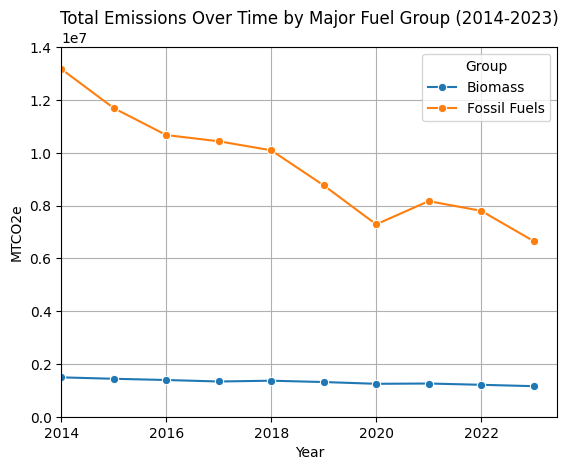

In [ ]:
total_emissions_by_group_and_year = carbon_intensity_summary.groupby(['Group', 'Year'])['Emissions (MTCO2e)'].sum().reset_index()
sns.lineplot(data=total_emissions_by_group_and_year,
             x='Year',
             y='Emissions (MTCO2e)',
             hue='Group',
             marker='o')
plt.ylabel('MTCO2e')
plt.title('Total Emissions Over Time by Major Fuel Group (2014-2023)')
plt.xlim(2014)
plt.ylim(0, 1.4e7)
plt.grid()
plt.show()

In [ ]:
ci_fossil = carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Fossil Fuels']
ci_fossil_summ = ci_fossil.groupby('Year')[['Electricity Generation', 'Emissions (MTCO2e)']].sum()
ci_fossil_summ['Carbon Intensity'] = ci_fossil_summ['Emissions (MTCO2e)'] / ci_fossil_summ['Electricity Generation']
ci_fossil_summ['Group'] = 'Fossil Fuels'
ci_fossil_summ.reset_index(inplace=True)
ci_fossil_summ.drop(['Electricity Generation', 'Emissions (MTCO2e)'], axis=1, inplace=True)
ci_fossil_summ

,Year,Carbon Intensity,Group
0,2014,0.004810,Fossil Fuels
1,2015,0.004305,Fossil Fuels
2,2016,0.004037,Fossil Fuels
3,2017,0.004132,Fossil Fuels
4,2018,0.003813,Fossil Fuels
5,2019,0.003407,Fossil Fuels
6,2020,0.003014,Fossil Fuels
7,2021,0.003271,Fossil Fuels
8,2022,0.003069,Fossil Fuels
9,2023,0.002663,Fossil Fuels


In [ ]:
ci_bio_summ = carbon_intensity_summary[carbon_intensity_summary['Source'] == 'Biomass'][['Year', 'Carbon Intensity']]
ci_bio_summ['Group'] = 'Biomass'
ci_bio_summ

,Year,Carbon Intensity,Group
0,2014,0.023297,Biomass
1,2015,0.022589,Biomass
2,2016,0.022160,Biomass
3,2017,0.021268,Biomass
4,2018,0.022062,Biomass
5,2019,0.022847,Biomass
6,2020,0.022789,Biomass
7,2021,0.023182,Biomass
8,2022,0.023323,Biomass
9,2023,0.024516,Biomass


In [ ]:
ci_by_group = pd.concat([ci_bio_summ, ci_fossil_summ], ignore_index=True)
ci_by_group

,Year,Carbon Intensity,Group
0,2014,0.023297,Biomass
1,2015,0.022589,Biomass
2,2016,0.022160,Biomass
3,2017,0.021268,Biomass
4,2018,0.022062,Biomass
5,2019,0.022847,Biomass
6,2020,0.022789,Biomass
7,2021,0.023182,Biomass
8,2022,0.023323,Biomass
9,2023,0.024516,Biomass


### Comparative Analysis

#### Assumption Checks

In [ ]:
# Checking for normality for each fuel group
from scipy.stats import shapiro
biomass_vals = ci_by_group[ci_by_group['Group'] == 'Biomass']['Carbon Intensity'].values
fossil_vals = ci_by_group[ci_by_group['Group'] == 'Fossil Fuels']['Carbon Intensity'].values

stat_bio, p_bio = shapiro(biomass_vals)
stat_fossil, p_fossil = shapiro(fossil_vals)

print(f"Biomass normality p-value: {p_bio:.4f}")
print(f"Fossil normality p-value: {p_fossil:.4f}")

Biomass normality p-value: 0.8834
Fossil normality p-value: 0.8893


**Purpose:** To confirm whether the distribution of carbon intensity values for each fuel group meets the normality assumption required for a parametric t-test.

**Intrepretation of results:** Both groups passed the normality test (p > 0.05), suggesting that carbon intensity values are approximately normally distributed and suitable for parametric analysis.

In [ ]:
# Checking for homogeneity of variances for each fuel group
from scipy.stats import levene
stat, p_levene = levene(biomass_vals, fossil_vals)
print(f"Levene’s test p-value: {p_levene:.4f}")

Levene’s test p-value: 0.7681


**Interpretation of results:** The high p-value indicates that variances are not significantly different, justifying the use of the Student's t-test.

#### Student's T-Test and Cohen's d (Effect Size)

In [ ]:
# Student's T-Test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(biomass_vals, fossil_vals)
print(f"T-test results: t = {t_stat:.4f}, p = {p_val:.4f}")

T-test results: t = 54.6337, p = 0.0000


**Interpretation of results:** The difference in average carbon intensity between biomass and fossil fuels is highly statistically significant, with biomass having consistently higher carbon intensity. This result is robust and unlikely due to chance.

In [ ]:
# Calculating Cohen's d (effect size)

# Computing means
mean_biomass = np.mean(biomass_vals)
mean_fossil = np.mean(fossil_vals)

# Computing standard deviations
std_biomass = np.std(biomass_vals, ddof=1)  # Use sample standard deviation (ddof=1)
std_fossil = np.std(fossil_vals, ddof=1)

# Computing pooled standard deviation
n_biomass = len(biomass_vals)
n_fossil = len(fossil_vals)
pooled_std = np.sqrt(
    ((n_biomass - 1) * std_biomass**2 + (n_fossil - 1) * std_fossil**2)
    / (n_biomass + n_fossil - 2)
)

# Calculating Cohen's d
cohen_d = (mean_biomass - mean_fossil) / pooled_std
print(f"Cohen's d: {cohen_d:.4f}")

Cohen's d: 24.4329


**Interpretation of results:** This is an extremely large effect size, reinforcing that the difference in carbon intensity is not only statistically significant but practically substantial. Biomass consistently emits much more CO₂ per unit of energy than fossil fuels in this dataset.

### Regression Trend Analysis (line plot with trend lines + model evaluation metrics)

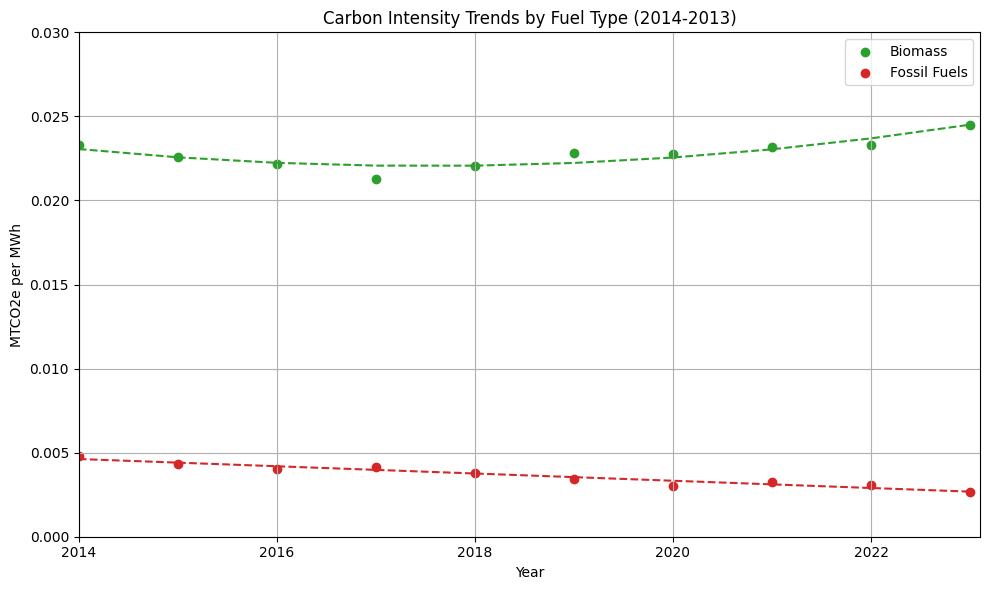

In [ ]:
import statsmodels.api as sm
# Splitting the data by group
biomass = ci_by_group[ci_by_group['Group'] == 'Biomass']
fossil = ci_by_group[ci_by_group['Group'] == 'Fossil Fuels']

# Biomass quadratic regression
biomass = biomass.copy()
biomass['Year2'] = biomass['Year']**2
X_bio = sm.add_constant(biomass[['Year', 'Year2']])
y_bio = biomass['Carbon Intensity']
bio_model = sm.OLS(y_bio, X_bio).fit()
year_range_bio = np.arange(biomass['Year'].min(), biomass['Year'].max() + 1)
year2_range_bio = year_range_bio**2
X_bio_pred = sm.add_constant(pd.DataFrame({'Year': year_range_bio, 'Year2': year2_range_bio}))
bio_y_pred = bio_model.predict(X_bio_pred)

# Fossil fuels linear regression
X_fossil = sm.add_constant(fossil['Year'])
y_fossil = fossil['Carbon Intensity']
fossil_model = sm.OLS(y_fossil, X_fossil).fit()
year_range_fossil = np.arange(fossil['Year'].min(), fossil['Year'].max() + 1)
X_fossil_pred = sm.add_constant(pd.Series(year_range_fossil, name='Year'))
fossil_y_pred = fossil_model.predict(X_fossil_pred)

# Creating a line plot of carbon intensity over time for each fuel group, including trend lines
plt.figure(figsize=(10, 6))

# Plotting biomass points and trend line
plt.scatter(biomass['Year'], biomass['Carbon Intensity'], color='tab:green', label='Biomass')
plt.plot(year_range_bio, bio_y_pred, color='tab:green', linestyle='--')

# Ploting fossil points and trend line
plt.scatter(fossil['Year'], fossil['Carbon Intensity'], color='tab:red', label='Fossil Fuels')
plt.plot(year_range_fossil, fossil_y_pred, color='tab:red', linestyle='--')

# Labels and formatting
plt.title('Carbon Intensity Trends by Fuel Type (2014-2013)')
plt.xlabel('Year')
plt.ylabel('MTCO2e per MWh')
plt.legend()
plt.tight_layout()
plt.grid()
plt.xlim(2014, 2023.1)
plt.ylim(0, 0.03)
plt.show()

In [ ]:
# Model evaluation metrics
print("Biomass R²:", bio_model.rsquared)
print("Biomass MAE:", np.mean(np.abs(bio_model.resid)))
print("Biomass RMSE:", np.sqrt(np.mean(bio_model.resid**2)))
print("\nFossil R²:", fossil_model.rsquared)
print("Fossil MAE:", np.mean(np.abs(fossil_model.resid)))
print("Fossil RMSE:", np.sqrt(np.mean(fossil_model.resid**2)))

Biomass R²: 0.8131182395306624
Biomass MAE: 0.00025178742587157917
Biomass RMSE: 0.00036060209563042173

Fossil R²: 0.9344907473048462
Fossil MAE: 0.00014519450517666777
Fossil RMSE: 0.00016390564815466842


In [ ]:
ci_reg_metrics = pd.DataFrame({'Metric': ['Biomass', 'Fossil Fuels'],
                               'R²': [0.8131, 0.9345],
                               'MAE': [0.00025, 0.00015],
                               'RMSE': [0.00036, 0.00016]})
ci_reg_metrics.index = ci_reg_metrics['Metric']
ci_reg_metrics.drop('Metric', axis=1, inplace=True)
ci_reg_metrics = ci_reg_metrics.transpose()
ci_reg_metrics

Metric,Biomass,Fossil Fuels
R²,0.81310,0.93450
MAE,0.00025,0.00015
RMSE,0.00036,0.00016


**Interpretation of results:**
* The quadratic model fits the biomass data well, revealing a U-shaped curve, with a drop in carbon intensity up to ~2017 followed by a steady increase in recent years — suggesting worsening per-unit emissions efficiency.
* Regarding the fossil fuel model, the strong linear fit indicates a clear downward trend, suggesting continued improvements in fossil fuel carbon efficiency (likely driven by shifts in fuel types or technology).

## Analysis #2: Energy  Efficiency

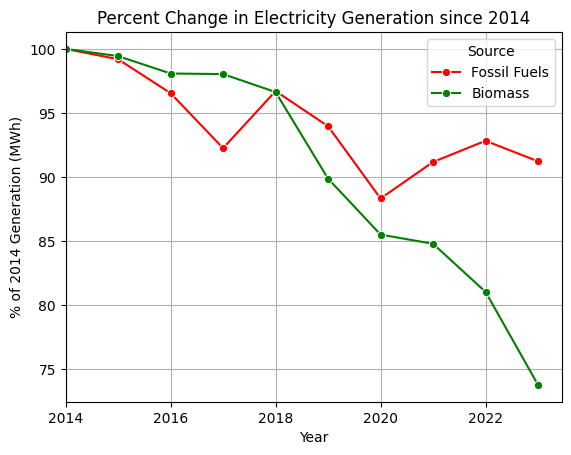

In [ ]:
elec_gen_all_sorted = elec_gen_all.sort_values(by='Year')
elec_gen_all_sorted['% of 2014 Generation'] = elec_gen_all_sorted.groupby('Source')['Electricity Generation'].transform(lambda x: (x / x.iloc[0]) * 100)
elec_gen_all_sorted['Source'] = elec_gen_all_sorted['Source'].str.replace('All Fossil Fuels', 'Fossil Fuels')
sns.lineplot(data=elec_gen_all_sorted[elec_gen_all_sorted['Source'].isin(['Biomass', 'Fossil Fuels'])],
             x='Year',
             y='% of 2014 Generation',
             hue='Source',
             marker='o',
             palette=['red', 'green'])
plt.ylabel('% of 2014 Generation (MWh)')
plt.title('Percent Change in Electricity Generation since 2014')
plt.xlim(2014)
plt.grid()
plt.show()

In [ ]:
energy_con.head()

,Year,Energy Source,Consumption
0,1949,Coal,11.980905
1,1950,Coal,12.347109
2,1951,Coal,12.552996
3,1952,Coal,11.306479
4,1953,Coal,11.372684


In [ ]:
energy_con.rename(columns={'Energy Source': 'Source'}, inplace=True)
display(energy_con[(energy_con['Source'] == 'Coal') & (energy_con['Year'] == 2010)])

,Year,Source,Consumption
61,2010,Coal,20.833968


In [ ]:
energy_con_summary = pd.DataFrame(energy_con[energy_con['Source'].isin(sources_of_interest)].groupby(['Source', 'Year'])['Consumption'].sum())
energy_con_summary.reset_index(inplace=True)
energy_con_summary = energy_con_summary[(energy_con_summary['Year'] >= 2014) & (energy_con_summary['Year'] <= 2023)]
energy_con_summary

,Source,Year,Consumption
65,Biomass,2014,5.012637
66,Biomass,2015,5.008496
67,Biomass,2016,5.052984
68,Biomass,2017,5.034529
69,Biomass,2018,5.094444
70,Biomass,2019,5.045931
71,Biomass,2020,4.535061
72,Biomass,2021,4.740480
73,Biomass,2022,4.846795
74,Biomass,2023,4.983857


In [ ]:
efficiency_summary = energy_con.merge(elec_gen_summary, on=['Source', 'Year'])
efficiency_summary

,Year,Source,Consumption,Electricity Generation
0,2014,Coal,17.997632,1581710000
1,2015,Coal,15.548870,1352398000
2,2016,Coal,14.225905,1239149000
3,2017,Coal,13.837465,1205835000
4,2018,Coal,13.251532,1149487000
5,2019,Coal,11.315595,964957000
6,2020,Coal,9.181109,773393000
7,2021,Coal,10.548526,897999000
8,2022,Coal,9.887939,831512000
9,2023,Coal,8.171931,675115000


In [ ]:
fossil_sources = ['Coal', 'Natural Gas', 'Petroleum']
efficiency_summary['Group'] = efficiency_summary['Source'].apply(lambda x: 'Fossil Fuels' if x in fossil_sources else x)
efficiency_summary

,Year,Source,Consumption,Electricity Generation,Group
0,2014,Coal,17.997632,1581710000,Fossil Fuels
1,2015,Coal,15.548870,1352398000,Fossil Fuels
2,2016,Coal,14.225905,1239149000,Fossil Fuels
3,2017,Coal,13.837465,1205835000,Fossil Fuels
4,2018,Coal,13.251532,1149487000,Fossil Fuels
5,2019,Coal,11.315595,964957000,Fossil Fuels
6,2020,Coal,9.181109,773393000,Fossil Fuels
7,2021,Coal,10.548526,897999000,Fossil Fuels
8,2022,Coal,9.887939,831512000,Fossil Fuels
9,2023,Coal,8.171931,675115000,Fossil Fuels


In [ ]:
eff_by_group = efficiency_summary.groupby(['Group', 'Year'])[['Electricity Generation', 'Consumption']].sum().reset_index()
eff_by_group['Efficiency'] = eff_by_group['Electricity Generation'] / eff_by_group['Consumption']
eff_by_group

,Group,Year,Electricity Generation,Consumption,Efficiency
0,Biomass,2014,63990000,5.012637,1.276574e+07
1,Biomass,2015,63632000,5.008496,1.270481e+07
2,Biomass,2016,62761000,5.052984,1.242058e+07
3,Biomass,2017,62733000,5.034529,1.246055e+07
4,Biomass,2018,61832000,5.094444,1.213714e+07
5,Biomass,2019,57506000,5.045931,1.139651e+07
6,Biomass,2020,54712000,4.535061,1.206423e+07
7,Biomass,2021,54252000,4.740480,1.144441e+07
8,Biomass,2022,51850000,4.846795,1.069779e+07
9,Biomass,2023,47200000,4.983857,9.470577e+06


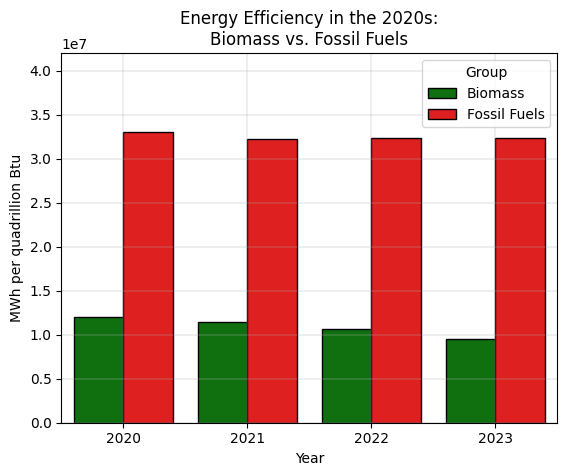

In [ ]:
sns.barplot(data=eff_by_group[eff_by_group['Year'] >= 2020],
            x='Year',
            y='Efficiency',
            hue='Group',
            palette=['Green', 'Red'],
            edgecolor='black')
plt.ylabel('MWh per quadrillion Btu')
plt.title('Energy Efficiency in the 2020s:\nBiomass vs. Fossil Fuels')
plt.ylim(0, 4.2e7)
plt.grid(linewidth=0.3)
plt.show()

In [ ]:
eff_2020s = eff_by_group[eff_by_group['Year'] >= 2020]
biomass_eff = eff_2020s[eff_2020s['Group'] == 'Biomass']['Efficiency']
fossil_eff = eff_2020s[eff_2020s['Group'] == 'Fossil Fuels']['Efficiency']

shapiro_biomass = shapiro(biomass_eff)
shapiro_fossil = shapiro(fossil_eff)

print(f"Shapiro p-value (Biomass): {shapiro_biomass.pvalue:.4f}")
print(f"Shapiro p-value (Fossil): {shapiro_fossil.pvalue:.4f}")
levene_test = levene(biomass_eff, fossil_eff)
print(f"Levene’s test p-value: {levene_test.pvalue:.4f}")

Shapiro p-value (Biomass): 0.8631
Shapiro p-value (Fossil): 0.0500
Levene’s test p-value: 0.1162


* Both groups meet the assumption of normality, though fossil fuels are borderline.
* Variance can be considered equal across the two groups; Student’s t-test is appropriate.

In [ ]:
# Student's T-Test
t_stat, p_val = ttest_ind(biomass_eff, fossil_eff)
print(f"T-test results: t = {abs(t_stat):.4f}, p = {p_val:.4f}")

T-test results: t = 36.5894, p = 0.0000


There is a highly significant difference in mean energy conversion efficiency between biomass and fossil fuels.

In [ ]:
# Calculating Cohen's d (effect size)

# Computing means
mean_biomass = np.mean(biomass_eff.values)
mean_fossil = np.mean(fossil_eff.values)

# Computing standard deviations
std_biomass = np.std(biomass_eff.values, ddof=1)  # Use sample standard deviation (ddof=1)
std_fossil = np.std(fossil_eff.values, ddof=1)

# Computing pooled standard deviation
n_biomass = len(biomass_eff.values)
n_fossil = len(fossil_eff.values)
pooled_std = np.sqrt(
    ((n_biomass - 1) * std_biomass**2 + (n_fossil - 1) * std_fossil**2)
    / (n_biomass + n_fossil - 2)
)

# Calculating Cohen's d
cohen_d = (mean_biomass - mean_fossil) / pooled_std
print(f"Cohen's d: {abs(cohen_d):.4f}")

Cohen's d: 25.8726


The difference between the two fuel groups is not only statistically significant but substantively large in magnitude.

## Analysis #3: Infrastructure Impact

In [ ]:
generators_df

,Energy Source,Total Capacity (MW),Average New Capacity (MW),Total Number of Plants,Total Number of Generators,Year,Total Construction Cost ($),Average Construction Cost ($/MW)
0,Natural gas,7411.0,176.452381,42,86,2013,7.152477e+09,9.651163e+05
1,Solar,2633.6,13.102488,201,250,2013,9.756707e+09,3.704703e+06
2,Wind,859.1,57.273333,15,22,2013,1.628190e+09,1.895227e+06
3,Biomass,799.6,12.692063,63,105,2013,2.794510e+09,3.494885e+06
4,Hydro,423.7,22.300000,19,21,2013,9.721752e+08,2.294489e+06
...,...,...,...,...,...,...,...,...
57,Solar,10709.0,28.000000,389,405,2022,1.700525e+10,1.587940e+06
58,Wind,7653.0,225.000000,34,37,2022,1.110265e+10,1.450758e+06
59,Natural gas,5419.0,181.000000,30,76,2022,4.441823e+09,8.196758e+05
60,Battery storage,3503.0,36.000000,97,104,2022,4.221310e+09,1.205056e+06


In [ ]:
sources_of_interest = ['Biomass', 'Natural gas', 'Petroleum liquids']
generators_filtered = generators_df[generators_df['Energy Source'].isin(sources_of_interest)]

generators_filtered['Group'] = generators_filtered['Energy Source'].apply(lambda x: 'Biomass' if x == 'Biomass' else 'Fossil Fuels')
generators_filtered = generators_filtered[['Year', 'Energy Source', 'Group', 'Average Construction Cost ($/MW)', 'Total Capacity (MW)']]
generators_filtered.head()

<ipython-input-59-174c9fa9464f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generators_filtered['Group'] = generators_filtered['Energy Source'].apply(lambda x: 'Biomass' if x == 'Biomass' else 'Fossil Fuels')


,Year,Energy Source,Group,Average Construction Cost ($/MW),Total Capacity (MW)
0,2013,Natural gas,Fossil Fuels,9.651163e+05,7411.0
3,2013,Biomass,Biomass,3.494885e+06,799.6
6,2013,Petroleum liquids,Fossil Fuels,7.645930e+05,71.0
7,2014,Natural gas,Fossil Fuels,1.016750e+06,9267.0
10,2014,Biomass,Biomass,1.987695e+06,243.0


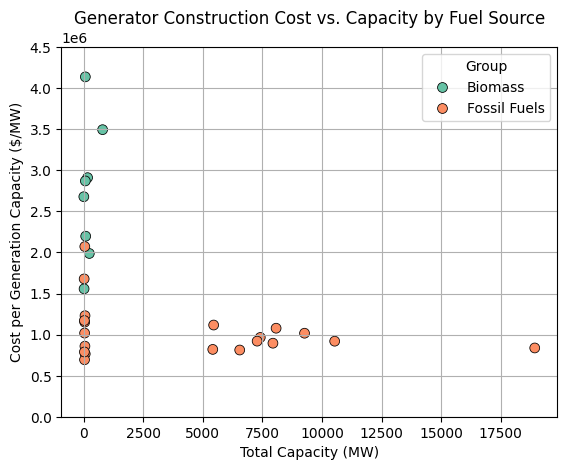

In [ ]:
sns.scatterplot(
    data=generators_filtered,
    x='Total Capacity (MW)',
    y='Average Construction Cost ($/MW)',
    hue='Group',
    hue_order=['Biomass', 'Fossil Fuels'],
    palette='Set2',
    s=50,
    edgecolor='black'
)
plt.ylabel('Cost per Generation Capacity ($/MW)')
plt.title('Generator Construction Cost vs. Capacity by Fuel Source')
plt.ylim(0, 4.5e6)
plt.grid()
plt.show()

In [ ]:
for group in ['Biomass', 'Fossil Fuels']:
    group_df = generators_filtered[generators_filtered['Group'] == group]
    corr_matrix = group_df[['Average Construction Cost ($/MW)',
                            'Total Capacity (MW)']].corr()
    print(f'{group} Cost-Capacity Correlation:')
    display(corr_matrix)

Biomass Cost-Capacity Correlation:


,Average Construction Cost ($/MW),Total Capacity (MW)
Average Construction Cost ($/MW),1.000000,0.334676
Total Capacity (MW),0.334676,1.000000


Fossil Fuels Cost-Capacity Correlation:


,Average Construction Cost ($/MW),Total Capacity (MW)
Average Construction Cost ($/MW),1.000000,-0.305364
Total Capacity (MW),-0.305364,1.000000


**Interpretation and Implications of Results:**
* Fossil fuels show a weak negative correlation (r = –0.31), suggesting that larger plants may achieve slightly lower per-MW costs — a possible, though modest, indication of economies of scale.
* Biomass shows a weak positive correlation (r = 0.33), implying that cost per MW may increase with capacity, possibly due to logistical, technological, or site-specific inefficiencies in scaling biomass projects.
* However, both correlation values are very weak by conventional standards (|r| < 0.4) and neither is statistically significant.
* Given these limitations, the observed relationships are suggestive at best — not strong enough to claim that one group has a “better” or more efficient cost-capacity dynamic.
* Still, the directional differences hint at structural challenges in scaling biomass infrastructure relative to fossil fuels.


## Analysis #4: Economic Performance (Fuel Price/Cost Trends & Stability)

In [ ]:
mdbfr_complete.head()

,month,roundwood/pulpwood_quantity_(tons),roundwood/pulpwood_cost_(usd_per_ton),sawmill_residuals_quantity_(tons),sawmill_residuals_cost_(usd_per_ton),wood_product_manufacturing_residuals_quantity_(tons),wood_product_manufacturing_residuals_cost_(usd_per_ton),other_residuals_quantity_(tons),other_residuals_cost_(usd_per_ton),year,dbf_quantity_(tons)_domestic,dbf_average_price_(usd_per_ton)_domestic,dbf_quantity_(tons)_export,dbf_average_price_(usd_per_ton)_export
0,1,152775,27.04,280632,36.16,127887,42.31,746574,31.72,2016,139893,162.25,318480,151.07
1,2,192635,29.18,183580,36.39,141275,39.03,443707,32.13,2016,90848,160.49,432018,145.75
2,3,117841,28.96,155382,35.80,161801,37.28,590026,31.89,2016,61153,157.18,459937,148.58
3,4,148456,23.09,197395,34.25,120862,38.19,509061,31.52,2016,72734,156.02,317594,155.75
4,5,206843,32.25,163278,33.66,120371,40.39,484391,31.52,2016,81223,156.97,417765,148.33


In [ ]:
fossil_costs.head()

,Year,Source,Average Cost ($/MMBtu)
0,2013,Coal,2.34
1,2014,Coal,2.37
2,2015,Coal,2.22
3,2016,Coal,2.11
4,2017,Coal,2.06


In [ ]:
print((mdbfr_complete['year'].min(), mdbfr_complete['year'].max()))
print((fossil_costs['Year'].min(), fossil_costs['Year'].max()))

(2016, 2024)
(2013, 2023)


In [ ]:
common_years = list(range(2016, 2024))
biomass_prices = mdbfr_complete[mdbfr_complete['year'].isin(common_years)][['year', 'dbf_average_price_(usd_per_ton)_domestic']]
biomass_prices = biomass_prices.groupby('year')['dbf_average_price_(usd_per_ton)_domestic'].mean().reset_index().rename(columns={'dbf_average_price_(usd_per_ton)_domestic':
                                                                                                                                   'Price ($/ton)'})
biomass_prices = biomass_prices.melt(id_vars='year', var_name='Metric', value_name='Value')
biomass_prices['Group'] = 'Biomass'
biomass_prices.columns = biomass_prices.columns.str.title()
biomass_prices

,Year,Metric,Value,Group
0,2016,Price ($/ton),160.923333,Biomass
1,2017,Price ($/ton),150.660833,Biomass
2,2018,Price ($/ton),153.123333,Biomass
3,2019,Price ($/ton),166.250000,Biomass
4,2020,Price ($/ton),173.505833,Biomass
5,2021,Price ($/ton),194.409167,Biomass
6,2022,Price ($/ton),203.990000,Biomass
7,2023,Price ($/ton),222.670833,Biomass


In [ ]:
all_fossil_costs = fossil_costs[(fossil_costs['Year'].isin(common_years)) & (fossil_costs['Source'] == 'All Fossil Fuels')][['Year', 'Average Cost ($/MMBtu)']]
all_fossil_costs.rename(columns={'Average Cost ($/MMBtu)': 'Cost ($/MMBtu)'}, inplace=True)
all_fossil_costs = all_fossil_costs.melt(id_vars='Year', var_name='Metric', value_name='Value')
all_fossil_costs['Group'] = 'Fossil Fuels'
all_fossil_costs

,Year,Metric,Value,Group
0,2016,Cost ($/MMBtu),2.47,Fossil Fuels
1,2017,Cost ($/MMBtu),2.65,Fossil Fuels
2,2018,Cost ($/MMBtu),2.83,Fossil Fuels
3,2019,Cost ($/MMBtu),2.50,Fossil Fuels
4,2020,Cost ($/MMBtu),2.22,Fossil Fuels
5,2021,Cost ($/MMBtu),3.82,Fossil Fuels
6,2022,Cost ($/MMBtu),5.22,Fossil Fuels
7,2023,Cost ($/MMBtu),3.12,Fossil Fuels


In [ ]:
cost_price_summary = pd.concat([biomass_prices, all_fossil_costs], ignore_index=True)
cost_price_summary

,Year,Metric,Value,Group
0,2016,Price ($/ton),160.923333,Biomass
1,2017,Price ($/ton),150.660833,Biomass
2,2018,Price ($/ton),153.123333,Biomass
3,2019,Price ($/ton),166.250000,Biomass
4,2020,Price ($/ton),173.505833,Biomass
5,2021,Price ($/ton),194.409167,Biomass
6,2022,Price ($/ton),203.990000,Biomass
7,2023,Price ($/ton),222.670833,Biomass
8,2016,Cost ($/MMBtu),2.470000,Fossil Fuels
9,2017,Cost ($/MMBtu),2.650000,Fossil Fuels


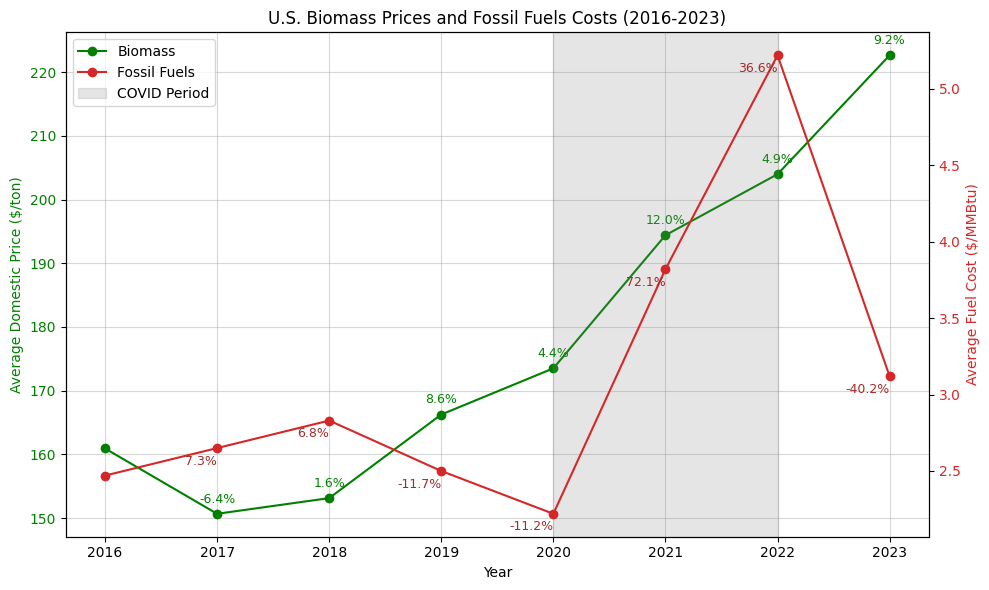

Note: Biomass values reflect domestic market prices of densified biomass fuel (a compressed form of organic material), primarily
wood pellets used for heating.
Reference: https://www.eia.gov/biofuels/biomass/?year=2024&month=12#about


In [ ]:
# Pivot and prep
pivot_df = cost_price_summary.pivot(index='Year', columns='Group', values='Value')

# Plot setup
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (Biomass)
color_biomass = 'green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Domestic Price ($/ton)', color=color_biomass)
ax1.plot(
    pivot_df.index,
    pivot_df['Biomass'],
    color=color_biomass,
    marker='o',
    label='Biomass'
)
ax1.tick_params(axis='y', labelcolor=color_biomass)

# Add gridlines to ax1
ax1.grid(True, which='both', axis='both', alpha=0.5)

# Secondary y-axis (Fossil Fuels)
ax2 = ax1.twinx()
color_fossil = 'tab:red'
ax2.set_ylabel('Average Fuel Cost ($/MMBtu)', color=color_fossil)
ax2.plot(
    pivot_df.index,
    pivot_df['Fossil Fuels'],
    color=color_fossil,
    marker='o',
    label='Fossil Fuels'
)
ax2.tick_params(axis='y', labelcolor=color_fossil)

# Shading the COVID period (2020-2022)
plt.axvspan(2020, 2022, color='gray', alpha=0.2, label='COVID Period')

# Sample data
years = biomass_prices['Year']
biomass_vals = biomass_prices['Value']
fossil_vals = all_fossil_costs['Value']

# Calculating Year-over-Year Percent Change for Biomass and Fossil Fuels
biomass_pct = biomass_vals.pct_change() * 100
fossil_pct = fossil_vals.pct_change() * 100

# Annotate YoY changes — Biomass
for i in range(1, len(years)):
    ax1.annotate(f'{biomass_pct.iloc[i]:.1f}%',
                 (years[i], biomass_vals.iloc[i]),
                 textcoords="offset points", xytext=(0, 8), ha='center',
                 fontsize=9, color='green')

# Annotate YoY changes — Fossil Fuels
for i in range(1, len(years)):
    ax2.annotate(f'{fossil_pct.iloc[i]:.1f}%',
                 (years[i], fossil_vals[i]),
                 textcoords="offset points", xytext=(0, -12), ha='right',
                 fontsize=9, color='brown')

# Title and formatting
plt.title('U.S. Biomass Prices and Fossil Fuels Costs (2016-2023)')
fig.tight_layout()

# Create custom legend from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)
plt.show()

# Caption
print(("Note: Biomass values reflect domestic market prices of \033[1mdensified biomass fuel\033[0m (a compressed form of organic material), primarily\nwood pellets used for heating."))
print('Reference: https://www.eia.gov/biofuels/biomass/?year=2024&month=12#about')

**Summary & Interpretation of Results:**
* Biomass prices followed a steady upward trend, with moderate year-over-year increases nearly every year. This consistency suggests relative stability in bioenergy markets over time.
* In contrast, fossil fuel costs showed a much more volatile trajectory, with a dramatic spike during the COVID-19 period (2021–2022), followed by a steep decline in 2023.
* The divergence in behavior is especially clear in 2021, when fossil fuel costs surged by over 70%, while biomass prices rose less than 12%.
* These patterns indicate that fossil fuel markets are more vulnerable to short-term shocks and global disruptions, whereas biomass has shown more predictable price dynamics.
* Although biomass prices are not immune to increases, their smoother trajectory could offer greater price stability, an important consideration for long-term energy planning and investment.


In [ ]:
pivot_df['Biomass Change'] = pivot_df['Biomass'].pct_change() * 100
pivot_df['Fossil Fuels Change'] = pivot_df['Fossil Fuels'].pct_change() * 100
pivot_df.drop(2016, inplace=True)
pivot_df.reset_index(inplace=True)
pivot_df

Group,Year,Biomass,Fossil Fuels,Biomass Change,Fossil Fuels Change
0,2017,150.660833,2.65,-6.377260,7.287449
1,2018,153.123333,2.83,1.634466,6.792453
2,2019,166.250000,2.50,8.572610,-11.660777
3,2020,173.505833,2.22,4.364411,-11.200000
4,2021,194.409167,3.82,12.047626,72.072072
5,2022,203.990000,5.22,4.928180,36.649215
6,2023,222.670833,3.12,9.157720,-40.229885


In [ ]:
pivot_df.drop(['Biomass', 'Fossil Fuels'], axis=1, inplace=True)
pivot_df_long = pivot_df.melt(id_vars='Year',
                         var_name='Group',
                         value_name='Percent Change')
pivot_df_long['Group'] = pivot_df_long['Group'].str.replace('Biomass Change', 'Biomass').str.replace('Fossil Fuels Change', 'Fossil Fuels')
pivot_df_long

,Year,Group,Percent Change
0,2017,Biomass,-6.377260
1,2018,Biomass,1.634466
2,2019,Biomass,8.572610
3,2020,Biomass,4.364411
4,2021,Biomass,12.047626
5,2022,Biomass,4.928180
6,2023,Biomass,9.157720
7,2017,Fossil Fuels,7.287449
8,2018,Fossil Fuels,6.792453
9,2019,Fossil Fuels,-11.660777


In [ ]:
pivot_df

Group,Year,Biomass Change,Fossil Fuels Change
0,2017,-6.377260,7.287449
1,2018,1.634466,6.792453
2,2019,8.572610,-11.660777
3,2020,4.364411,-11.200000
4,2021,12.047626,72.072072
5,2022,4.928180,36.649215
6,2023,9.157720,-40.229885


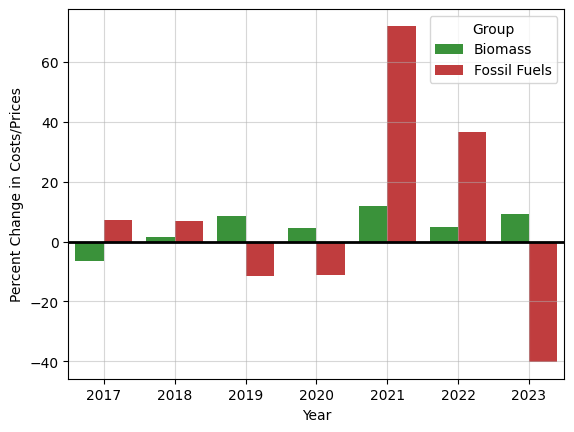

In [ ]:
sns.barplot(data=pivot_df_long,
            x='Year',
            y='Percent Change',
            hue='Group',
            palette=['tab:green', 'tab:red'])
plt.ylabel('Percent Change in Costs/Prices')
plt.axhline(y=0, color='black', linewidth=2)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# Mann-Whitney U Test Using Raw Percent-Change Values
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(pivot_df['Biomass Change'], pivot_df['Fossil Fuels Change'], alternative='two-sided')
print(f"Mann-Whitney U test statistic = {stat}, p-value = {p:.4}")

Mann-Whitney U test statistic = 27.0, p-value = 0.8048


In [ ]:
# Mann-Whitney U Test Using Absolute Percent-Change Values
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(pivot_df['Biomass Change'].abs(), pivot_df['Fossil Fuels Change'].abs(), alternative='two-sided')
print(f"Mann-Whitney U test statistic = {stat}, p-value = {p:.4}")

Mann-Whitney U test statistic = 8.0, p-value = 0.03788


**Interpretation and Implications of Results:**
* When comparing the raw percent-change values, there was no statistically significant difference between biomass and fossil fuels (p = 0.80). This suggests that the direction and magnitude of yearly changes varied similarly across groups when considering increases and decreases together.
* However, when looking at the absolute percent-change values — which capture volatility regardless of direction — the difference was statistically significant (p = 0.038).
* These findings support the earlier visual observation that fossil fuel costs exhibited greater year-to-year volatility than biomass fuel prices over the 2017-2023 period.


## Appendix

### Summary Table for descriptive statistics section of the presentation

In [ ]:
carbon_intensity_summary.head()

,Source,Year,Emissions (MTCO2e),Electricity Generation,Carbon Intensity,Group
0,Biomass,2014,1490791.671,63990000,0.023297,Biomass
1,Biomass,2015,1437394.986,63632000,0.022589,Biomass
2,Biomass,2016,1390803.140,62761000,0.022160,Biomass
3,Biomass,2017,1334236.098,62733000,0.021268,Biomass
4,Biomass,2018,1364168.142,61832000,0.022062,Biomass


In [ ]:
(carbon_intensity_summary['Year'].min(), carbon_intensity_summary['Year'].max())

(2014, 2023)

In [ ]:
eff_by_group.head()

,Group,Year,Electricity Generation,Consumption,Efficiency
0,Biomass,2014,63990000,5.012637,1.276574e+07
1,Biomass,2015,63632000,5.008496,1.270481e+07
2,Biomass,2016,62761000,5.052984,1.242058e+07
3,Biomass,2017,62733000,5.034529,1.246055e+07
4,Biomass,2018,61832000,5.094444,1.213714e+07


In [ ]:
eff_by_group['Year'].describe()[['min', 'max']]

,Year
min,2014.0
max,2023.0


In [ ]:
cost_price_summary.head()

,Year,Metric,Value,Group
0,2016,Price ($/ton),160.923333,Biomass
1,2017,Price ($/ton),150.660833,Biomass
2,2018,Price ($/ton),153.123333,Biomass
3,2019,Price ($/ton),166.250000,Biomass
4,2020,Price ($/ton),173.505833,Biomass


In [ ]:
cost_price_summary['Year'].describe()[['min', 'max']]

,Year
min,2016.0
max,2023.0


In [ ]:
generators_filtered.head()

,Year,Energy Source,Group,Average Construction Cost ($/MW),Total Capacity (MW)
0,2013,Natural gas,Fossil Fuels,9.651163e+05,7411.0
3,2013,Biomass,Biomass,3.494885e+06,799.6
6,2013,Petroleum liquids,Fossil Fuels,7.645930e+05,71.0
7,2014,Natural gas,Fossil Fuels,1.016750e+06,9267.0
10,2014,Biomass,Biomass,1.987695e+06,243.0


In [ ]:
generators_filtered['Year'].describe()[['min', 'max']]

,Year
min,2013.0
max,2022.0


In [ ]:
generators_df.head()

,Energy Source,Total Capacity (MW),Average New Capacity (MW),Total Number of Plants,Total Number of Generators,Year,Total Construction Cost ($),Average Construction Cost ($/MW)
0,Natural gas,7411.0,176.452381,42,86,2013,7.152477e+09,9.651163e+05
1,Solar,2633.6,13.102488,201,250,2013,9.756707e+09,3.704703e+06
2,Wind,859.1,57.273333,15,22,2013,1.628190e+09,1.895227e+06
3,Biomass,799.6,12.692063,63,105,2013,2.794510e+09,3.494885e+06
4,Hydro,423.7,22.300000,19,21,2013,9.721752e+08,2.294489e+06


In [ ]:
generators_df['Energy Source'].unique()

array(['Natural gas', 'Solar', 'Wind', 'Biomass', 'Hydro', 'Geothermal',
       'Petroleum liquids', 'Battery storage'], dtype=object)

In [ ]:
generators_summary = generators_df.copy()

sources_of_interest = ['Biomass', 'Natural gas', 'Petroleum liquids']
generators_summary = generators_summary[generators_summary['Energy Source'].isin(sources_of_interest)]

fossil_sources = [source for source in sources_of_interest if source != 'Biomass']
generators_summary['Group'] = generators_summary['Energy Source'].apply(lambda x: 'Fossil Fuels' if x in fossil_sources else x)

generators_summary = generators_summary.groupby(['Group', 'Year'])[['Total Capacity (MW)', 'Total Construction Cost ($)']].sum().reset_index()
generators_summary['Cost per MW'] = generators_summary['Total Construction Cost ($)'] / generators_summary['Total Capacity (MW)']
generators_summary = generators_summary[['Group', 'Year', 'Total Capacity (MW)', 'Cost per MW']]

for group in generators_summary['Group'].unique():
    print(f"{group} available years:\n{generators_summary[generators_summary['Group'] == group]['Year'].unique()}\n")

Biomass available years:
[2013 2014 2015 2016 2017 2019 2020 2021]

Fossil Fuels available years:
[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]



In [ ]:
generators_summary_filtered = generators_summary[generators_summary['Year'].isin([2016, 2019, 2021])]
generators_summary_filtered

,Group,Year,Total Capacity (MW),Cost per MW
3,Biomass,2016,91.0,2.197758e+06
5,Biomass,2019,170.0,2.910724e+06
7,Biomass,2021,12.0,2.678583e+06
11,Fossil Fuels,2016,7968.0,8.977541e+05
14,Fossil Fuels,2019,8124.0,1.078098e+06
16,Fossil Fuels,2021,7315.0,9.214972e+05


In [ ]:
ci_summary_filtered = carbon_intensity_summary[carbon_intensity_summary['Year'].isin([2016, 2019, 2021])].groupby(['Group', 'Year'])[['Emissions (MTCO2e)', 'Electricity Generation']].sum().reset_index()
ci_summary_filtered['Carbon Intensity'] = ci_summary_filtered['Emissions (MTCO2e)'] / ci_summary_filtered['Electricity Generation']
ci_summary_filtered

,Group,Year,Emissions (MTCO2e),Electricity Generation,Carbon Intensity
0,Biomass,2016,1.390803e+06,62761000,0.022160
1,Biomass,2019,1.313838e+06,57506000,0.022847
2,Biomass,2021,1.257650e+06,54252000,0.023182
3,Fossil Fuels,2016,1.066937e+07,2642625000,0.004037
4,Fossil Fuels,2019,8.763504e+06,2571831000,0.003407
5,Fossil Fuels,2021,8.166105e+06,2496363000,0.003271


In [ ]:
eff_summary_filtered = eff_by_group[eff_by_group['Year'].isin([2016, 2019, 2021])]
eff_summary_filtered

,Group,Year,Electricity Generation,Consumption,Efficiency
2,Biomass,2016,62761000,5.052984,1.242058e+07
5,Biomass,2019,57506000,5.045931,1.139651e+07
7,Biomass,2021,54252000,4.740480,1.144441e+07
12,Fossil Fuels,2016,2642625000,78.338160,3.373356e+07
15,Fossil Fuels,2019,2571831000,80.445668,3.196979e+07
17,Fossil Fuels,2021,2496363000,77.502376,3.221015e+07


In [ ]:
cost_price_summary_filtered = cost_price_summary[cost_price_summary['Year'].isin([2016, 2019, 2021])]
cost_price_summary_filtered

,Year,Metric,Value,Group
0,2016,Price ($/ton),160.923333,Biomass
3,2019,Price ($/ton),166.250000,Biomass
5,2021,Price ($/ton),194.409167,Biomass
8,2016,Cost ($/MMBtu),2.470000,Fossil Fuels
11,2019,Cost ($/MMBtu),2.500000,Fossil Fuels
13,2021,Cost ($/MMBtu),3.820000,Fossil Fuels


In [ ]:
ci_summary_filtered[ci_summary_filtered['Group'] == 'Biomass']

,Group,Year,Emissions (MTCO2e),Electricity Generation,Carbon Intensity
0,Biomass,2016,1390803.140,62761000,0.022160
1,Biomass,2019,1313838.498,57506000,0.022847
2,Biomass,2021,1257649.520,54252000,0.023182


In [ ]:
eff_summary_filtered[eff_summary_filtered['Group'] == 'Biomass']

,Group,Year,Electricity Generation,Consumption,Efficiency
2,Biomass,2016,62761000,5.052984,1.242058e+07
5,Biomass,2019,57506000,5.045931,1.139651e+07
7,Biomass,2021,54252000,4.740480,1.144441e+07


In [ ]:
generators_summary_filtered[generators_summary_filtered['Group'] == 'Biomass']

,Group,Year,Total Capacity (MW),Cost per MW
3,Biomass,2016,91.0,2.197758e+06
5,Biomass,2019,170.0,2.910724e+06
7,Biomass,2021,12.0,2.678583e+06


In [ ]:
bio_summary_table_complete = pd.DataFrame({'Year': [2016, 2019, 2021]})
for idx, row in bio_summary_table_complete.iterrows():
    year = row['Year']
    bio_summary_table_complete.loc[idx, 'Carbon Intensity\n(MTCO2e / MWh)'] = ci_summary_filtered[(ci_summary_filtered['Group'] == 'Biomass') & (ci_summary_filtered['Year'] == year)]['Carbon Intensity'].reset_index(drop=True).iloc[0]
    bio_summary_table_complete.loc[idx, 'Energy Conversion Efficiency\n(MWh / Quad. Btu)'] = eff_summary_filtered[(eff_summary_filtered['Group'] == 'Biomass') & (eff_summary_filtered['Year'] == year)]['Efficiency'].reset_index(drop=True).iloc[0]
    bio_summary_table_complete.loc[idx, 'Construction Cost Per\nGeneration Capacity\n($/MW)'] = generators_summary_filtered[(generators_summary_filtered['Group'] == 'Biomass') & (generators_summary_filtered['Year'] == year)]['Cost per MW'].reset_index(drop=True).iloc[0]
    bio_summary_table_complete.loc[idx, 'Fuel Price\n($/ton)'] = cost_price_summary_filtered[(cost_price_summary_filtered['Group'] == 'Biomass') & (cost_price_summary_filtered['Year'] == year)]['Value'].reset_index(drop=True).iloc[0]
for col in bio_summary_table_complete.columns[1:]:
    bio_summary_table_complete[col] = bio_summary_table_complete[col].apply(lambda x: f"{x:,.4f}")

bio_summary_table_complete.style.set_table_styles([
    {"selector": "th", "props": [("white-space", "pre-wrap"), ("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
])

,Year,Carbon Intensity (MTCO2e / MWh),Energy Conversion Efficiency (MWh / Quad. Btu),Construction Cost Per Generation Capacity ($/MW),Fuel Price ($/ton)
0,2016,0.0222,"12,420,581.5811","2,197,758.2418",160.9233
1,2019,0.0228,"11,396,509.3855","2,910,723.5294",166.2500
2,2021,0.0232,"11,444,410.6926","2,678,583.3333",194.4092


In [ ]:
fossil_summary_table_complete = pd.DataFrame({'Year': [2016, 2019, 2021]})
for idx, row in fossil_summary_table_complete.iterrows():
    year = row['Year']
    fossil_summary_table_complete.loc[idx, 'Carbon Intensity\n(MTCO2e / MWh)'] = ci_summary_filtered[(ci_summary_filtered['Group'] == 'Fossil Fuels') & (ci_summary_filtered['Year'] == year)]['Carbon Intensity'].reset_index(drop=True).iloc[0]
    fossil_summary_table_complete.loc[idx, 'Energy Conversion Efficiency\n(MWh / Quad. Btu)'] = eff_summary_filtered[(eff_summary_filtered['Group'] == 'Fossil Fuels') & (eff_summary_filtered['Year'] == year)]['Efficiency'].reset_index(drop=True).iloc[0]
    fossil_summary_table_complete.loc[idx, 'Construction Cost Per\nGeneration Capacity\n($/MW)'] = generators_summary_filtered[(generators_summary_filtered['Group'] == 'Fossil Fuels') & (generators_summary_filtered['Year'] == year)]['Cost per MW'].reset_index(drop=True).iloc[0]
    fossil_summary_table_complete.loc[idx, 'Fuel Cost\n($/MMBtu)'] = cost_price_summary_filtered[(cost_price_summary_filtered['Group'] == 'Fossil Fuels') & (cost_price_summary_filtered['Year'] == year)]['Value'].reset_index(drop=True).iloc[0]
for col in fossil_summary_table_complete.columns[1:]:
    fossil_summary_table_complete[col] = fossil_summary_table_complete[col].apply(lambda x: f"{x:,.4f}")

fossil_summary_table_complete.style.set_table_styles([
    {"selector": "th", "props": [("white-space", "pre-wrap"), ("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
])

,Year,Carbon Intensity (MTCO2e / MWh),Energy Conversion Efficiency (MWh / Quad. Btu),Construction Cost Per Generation Capacity ($/MW),Fuel Cost ($/MMBtu)
0,2016,0.0040,"33,733,559.7364","897,754.1416",2.4700
1,2019,0.0034,"31,969,788.6032","1,078,098.1044",2.5000
2,2021,0.0033,"32,210,147.9831","921,497.1975",3.8200


### KDE plots for the descriptive statistics section of the presentation

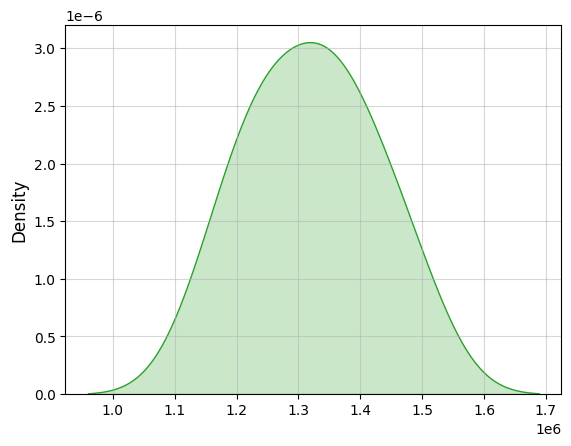

In [ ]:
sns.kdeplot(data=carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Biomass'],
            x='Emissions (MTCO2e)',
            fill=True,
            color='tab:green')
#plt.title('Biomass', fontsize=15)
#plt.xlabel('Emissions (MTCO2e)', fontsize=12)
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

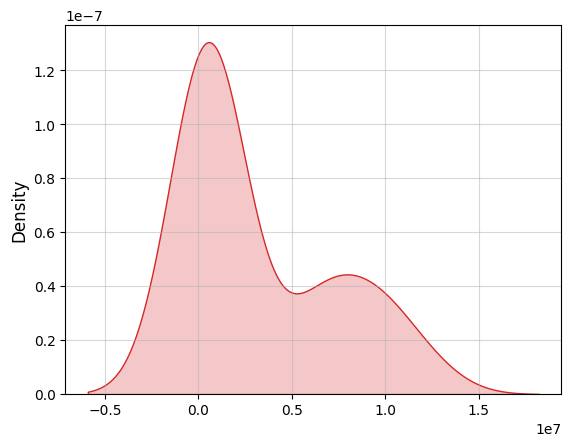

In [ ]:
sns.kdeplot(data=carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Fossil Fuels'],
            x='Emissions (MTCO2e)',
            fill=True,
            color='tab:red')
#plt.title('Fossil Fuels', fontsize=15)
#plt.xlabel('Emissions (MTCO2e)', fontsize=12)
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
print('Biomass:', list(carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Biomass']['Emissions (MTCO2e)']))
print('Fossil Fuels:', list(carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Fossil Fuels']['Emissions (MTCO2e)']))

Biomass: [1490791.671, 1437394.986, 1390803.14, 1334236.098, 1364168.142, 1313838.498, 1246843.69, 1257649.52, 1209303.041, 1157177.0862791587]
Fossil Fuels: [12194381.854, 10661954.584, 9660376.442, 9424619.866, 9007227.4, 7637590.0, 6165102.456, 7055289.636, 6632771.992, 5462237.144, 793099.4712453118, 860165.5326608858, 852868.3690305304, 835558.738623863, 919906.6662002645, 985611.7738616139, 983489.5297452811, 983351.0652556813, 1024432.5363228926, 1075935.595734472, 183765.003, 167198.852, 156120.686, 173284.683, 165080.726, 140302.587, 138338.504, 127464.673, 141557.219, 113060.16703217455]


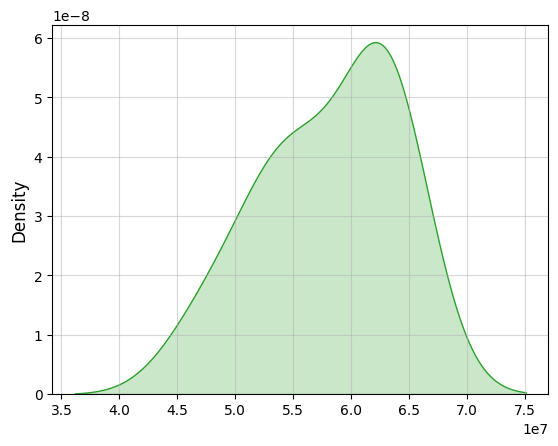

In [ ]:
sns.kdeplot(data=carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Biomass'],
            x='Electricity Generation',
            fill=True,
            color='tab:green')
#plt.title('Biomass')
#plt.xlabel('Electricity Generation (MWh)')
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

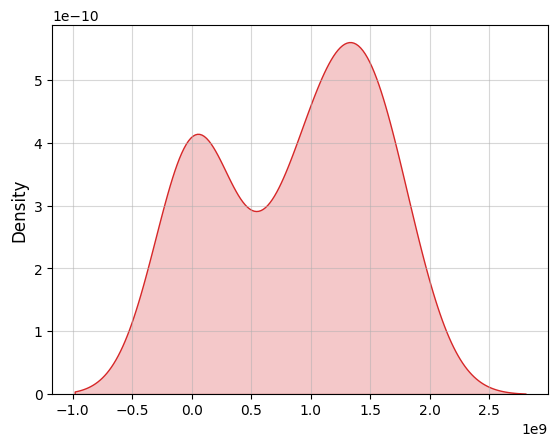

In [ ]:
sns.kdeplot(data=carbon_intensity_summary[carbon_intensity_summary['Group'] == 'Fossil Fuels'],
            x='Electricity Generation',
            fill=True,
            color='tab:red')
#plt.title('Fossil Fuels')
#plt.xlabel('Electricity Generation (MWh)')
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

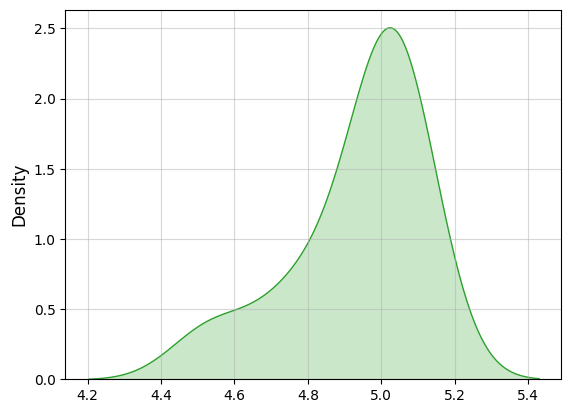

In [ ]:
sns.kdeplot(data=efficiency_summary[efficiency_summary['Group'] == 'Biomass'],
            x='Consumption',
            fill=True,
            color='tab:green')
#plt.title('Biomass')
#plt.xlabel('Consumption (Quadrillion Btu)')
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

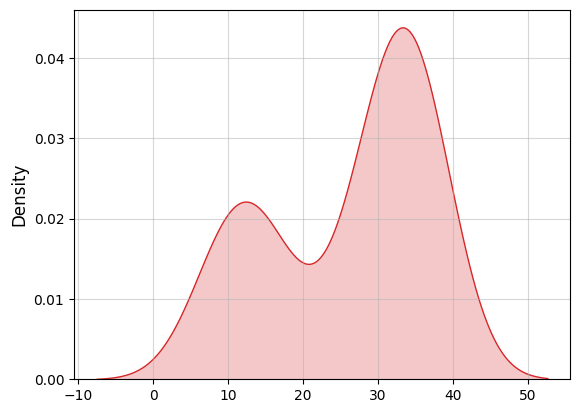

In [ ]:
sns.kdeplot(data=efficiency_summary[efficiency_summary['Group'] == 'Fossil Fuels'],
            x='Consumption',
            fill=True,
            color='tab:red')
#plt.title('Fossil Fuels')
#plt.xlabel('Consumption (Quadrillion Btu)')
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

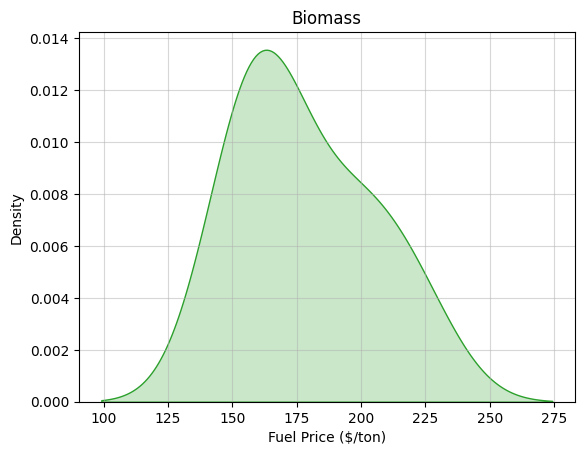

In [ ]:
sns.kdeplot(data=cost_price_summary[cost_price_summary['Group'] == 'Biomass'],
            x='Value',
            fill=True,
            color='tab:green')
plt.title('Biomass')
plt.xlabel('Fuel Price ($/ton)')
plt.grid(alpha=0.5)
plt.show()

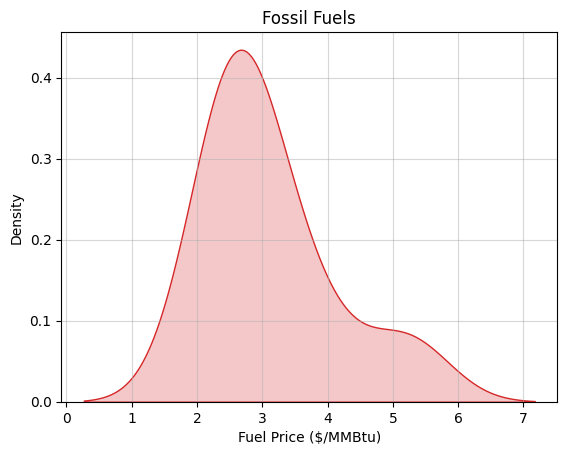

In [ ]:
sns.kdeplot(data=cost_price_summary[cost_price_summary['Group'] == 'Fossil Fuels'],
            x='Value',
            fill=True,
            color='tab:red')
plt.title('Fossil Fuels')
plt.xlabel('Fuel Price ($/MMBtu)')
plt.grid(alpha=0.5)
plt.show()

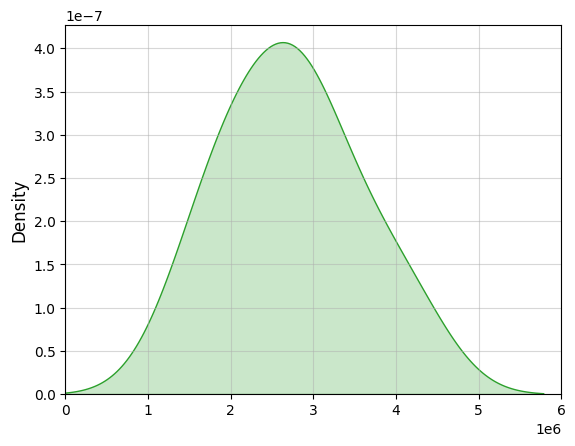

In [ ]:
sns.kdeplot(data=generators_filtered[generators_filtered['Group'] == 'Biomass'],
            x='Average Construction Cost ($/MW)',
            fill=True,
            color='tab:green')
#plt.title('Biomass')
#plt.xlabel('Average Generator Construction Cost ($/MW)')
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, 6e6)
plt.grid(alpha=0.5)
plt.show()

In [ ]:
generators_filtered[generators_filtered['Group'] == 'Biomass']['Average Construction Cost ($/MW)'].describe()[['min', 'max']]

,Average Construction Cost ($/MW)
min,1.557261e+06
max,4.138066e+06


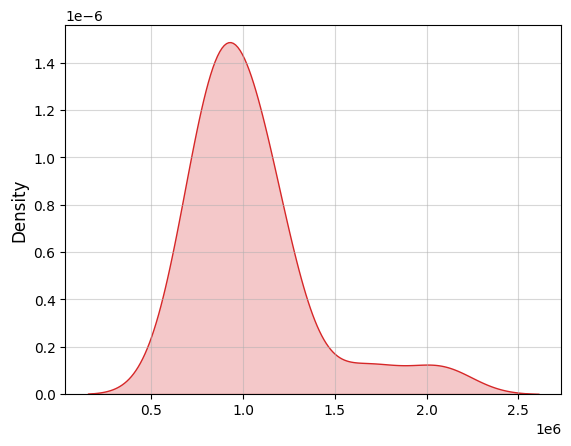

In [ ]:
sns.kdeplot(data=generators_filtered[generators_filtered['Group'] == 'Fossil Fuels'],
            x='Average Construction Cost ($/MW)',
            fill=True,
            color='tab:red')
#plt.title('Fossil Fuels')
#plt.xlabel('Average Generator Construction Cost ($/MW)')
plt.xlabel(None)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.5)
plt.show()